In [7]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [30]:
class ImgNN(nn.Module):

  def __init__(self, hidden_size, layer_count, freqs=8):
      super().__init__()
      self.freqs = freqs
      self.in_proj = nn.Linear(freqs * 2, hidden_size) # nn.Linear(2, hidden_size)#
      self.out_proj = nn.Linear(hidden_size, 4)
      self.layers = [self.in_proj]
      for _ in range(layer_count):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.ReLU())
      self.layers.append(self.out_proj)
      self.layers = nn.Sequential( *self.layers )
  
  def to_freq(self, coords):
    return torch.hstack([
      torch.outer(0.01*coords[:, 0], 2 ** torch.arange(8)).sin(),
      torch.outer(0.01*coords[:, 1], 2 ** torch.arange(8)).sin()
    ])

  def forward(self, coords):
      return self.layers(self.to_freq(coords))
      #return self.layers(0.005*coords)

In [31]:
img = torchvision.io.read_image("horsy.png")

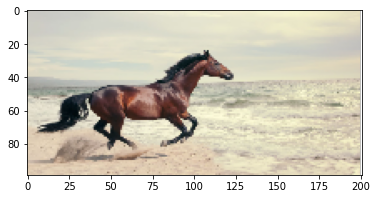

In [32]:
plt.imshow(img.permute(1, 2, 0))

In [33]:
img.shape

torch.Size([4, 99, 201])

In [34]:
class PixelDataset(Dataset):
    def __init__(self, base_image):
      self.pixels = []
      img = base_image.permute(1, 2, 0) / 255.0
      for y, col in enumerate(img):
        for x, pixel in enumerate(col):
          self.pixels.append((torch.tensor([x, y], dtype=torch.float), pixel))

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        return self.pixels[idx]

In [35]:
pix_dat = PixelDataset(img)

In [36]:
def make_img_coords(width, height):
  X, Y = np.mgrid[0:width, 0:height]
  return np.dstack([Y.ravel(), X.ravel()])[0]

In [40]:
imgNN = ImgNN(256, 3)
#opt = torch.optim.SGD(imgNN.parameters(), lr=0.001, momentum=0.9)
opt = torch.optim.Adam(imgNN.parameters(), lr=0.001)
train_dataloader = DataLoader(pix_dat, batch_size=512, shuffle=True)
for epoch in range(100):
    for xb, yb in train_dataloader:
        pred = imgNN(xb)
        loss = ((pred - yb) ** 2).mean()

        loss.backward()
        #print(loss.item())
        opt.step()
        opt.zero_grad()
    print(loss.item())

0.027793901041150093
0.02135307528078556
0.01928737387061119
0.016002140939235687
0.01446128822863102
0.011941377073526382
0.008482423610985279
0.009778229519724846
0.006164133548736572
0.0054579866118729115
0.007025487255305052
0.0049536400474607944
0.00553581677377224
0.004653135314583778
0.003834610339254141
0.004517924506217241
0.004433988593518734
0.0027500574942678213
0.0036066577304154634
0.002575399586930871
0.0023799980990588665
0.0035110025200992823
0.003043567994609475
0.00246276892721653
0.003041564952582121
0.003354074666276574
0.0024537555873394012
0.0021553158294409513
0.002573383040726185
0.00238240254111588
0.0025454324204474688
0.0021799495443701744
0.0019169037695974112
0.0024332385510206223
0.0021374118514358997
0.0027541453018784523
0.0020053060725331306
0.0024273362942039967
0.0025639671366661787
0.0016483536455780268
0.0021496887784451246
0.001923304283991456
0.0018484850879758596
0.0016470790142193437
0.002511337399482727
0.0015275238547474146
0.0017614417010918

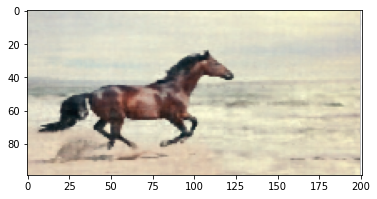

In [41]:
result_pixs = imgNN( 
    torch.tensor(make_img_coords(img.shape[1], img.shape[2]), dtype=torch.float) 
    ).detach()
img_pix = result_pixs.reshape(img.shape[1], img.shape[2], 4)
plt.imshow(img_pix)